# Imports

put comments here related to library management

In [234]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tempfile
import zipfile


from tensorflow.keras import layers
from IPython import display
import keras_tuner as kt

from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Activation, Input, Reshape, Multiply, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, ReLU, Dropout
from tensorflow.keras import Sequential

import tensorflow_model_optimization as tfmot
#from tensorflow_model_optimization.python.core.keras.compat import keras
from keras.layers import Resizing
from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer

import nbimporter

import tf_keras as keras

# Run .py preprocessing that sets up the datasets

In [2]:
# Function to parse a single serialized example from TFRecord
def _parse_function(proto):
    # Define the feature description (same as the structure you used when saving)
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Image is stored as a string
        'label': tf.io.FixedLenFeature([], tf.int64),   # Label is an int64
    }
    
    # Parse the input `tf.train.Example` proto using the feature description
    parsed_example = tf.io.parse_single_example(proto, feature_description)
    
    # Decode the JPEG-encoded image back into a float32 tensor
    image = tf.io.decode_jpeg(parsed_example['image'], channels=1)  # Grayscale
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to [0, 1] range
    
    # Reshape the image to its original shape (e.g., [124, 129, 1])
    image = tf.reshape(image, [124, 129, 1])
    
    # Get the label
    label = parsed_example['label']
    
    return image, label

In [3]:
# Function to load the dataset from a TFRecord file
def load_dataset(tfrecord_file, batch_size=64):
    # Load the TFRecord file
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    
    # Parse the serialized data using the _parse_function
    parsed_dataset = raw_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and shuffle the dataset (optional, depending on your needs) buffer_size is not size of batch its size of buffer
    parsed_dataset = parsed_dataset.shuffle(buffer_size=1000).batch(batch_size)
    parsed_dataset = parsed_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return parsed_dataset

In [4]:
# Load the train, test, and validation datasets from TFRecord files
train_spectrogram_ds = load_dataset('train_spec_ds.tfrecord')
test_spectrogram_ds = load_dataset('test_spec_ds.tfrecord')
val_spectrogram_ds = load_dataset('val_spec_ds.tfrecord')

In [235]:
new_size = len(list(train_spectrogram_ds))
print(f"New dataset size: {new_size}")

# Get input shape and number of classes
for spectrograms, labels in train_spectrogram_ds.take(1):
    input_shape = spectrograms.shape
    num_classes = 6
    print('Input shape:', input_shape)
    print('Number of classes:', num_classes)

New dataset size: 213
Input shape: (64, 124, 129, 1)
Number of classes: 6


In [6]:
new_size = len(list(test_spectrogram_ds))
print(f"New dataset size: {new_size}")

New dataset size: 27


# Define models

In [7]:
import audio_models

## Keras autotuner

In [159]:
train_spectrogram_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [161]:
# Define a directory to store tuner results
tuner_dir = 'my_dir'
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)  # Remove existing tuner directory to start fresh

def build_model(hp):
    """Build model with validation checks that allow skipping invalid configurations."""
    model = tf.keras.Sequential()
    input_shape = (124, 129, 1)
    model.add(layers.Input(shape=input_shape))
    
    current_height, current_width = input_shape[0], input_shape[1]
    
    # Track if the configuration is valid
    is_valid = True
    
    # Convolutional layers with tunable filters, kernel size, and stride
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        kernel_size = hp.Choice(f'kernel_size_{i}', values=[6, 8, 10, 12])
        stride = hp.Choice(f'stride_{i}', values=[2, 4, 8, 10, 12])
        
        # Calculate new spatial dimensions
        new_height = (current_height - kernel_size) // stride + 1
        new_width = (current_width - kernel_size) // stride + 1
        
        # Check if dimensions are valid
        if new_height <= 0 or new_width <= 0:
            print(f"Invalid dimensions after Conv2D with kernel {kernel_size} and stride {stride}")
            is_valid = False
            break

        # Add the convolutional and pooling layers
        model.add(layers.Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=6, max_value=12, step=2),
            kernel_size=kernel_size,
            strides=stride,
            activation='relu'
        ))
        #model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
        # Update spatial dimensions after pooling
        #current_height, current_width = new_height // 2, new_width // 2
        #if current_height <= 0 or current_width <= 0:
        #    print("Invalid dimensions after MaxPooling")
        #    is_valid = False
        #    break
        if is_valid:
            model.add(layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3])))

    if is_valid:
        # Dropout layer
        #model.add(layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.1, 0.25, 0.5])))
        
        # Flatten layer
        model.add(layers.Flatten())
        
        # Optional fully connected layer
        #if hp.Boolean('use_dense_layer'):
        #    model.add(layers.Dense(
        #        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        #        activation='relu'
        #    ))
        
        # Check parameter count
        model_params = model.count_params()
        if model_params > 40000:
            print(f"Model exceeds parameter limit: {model_params} params")
            is_valid = False
    
    if not is_valid:
        # Return an invalid model that will get a very low accuracy
        print("Skipping invalid configuration...")
        model = tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(6, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        # Set a custom property to identify invalid models
        model.is_invalid = True
        return model
    
    # Output layer for valid models
    model.add(layers.Dense(6, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.is_invalid = False
    return model

# Custom tuner class to handle invalid models
class CustomRandomSearch(kt.RandomSearch):
    def run_trial(self, trial, *fit_args, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        if hasattr(model, 'is_invalid') and model.is_invalid:
            # For invalid models, return a fixed low score without training
            return {'val_accuracy': float('-inf')}
            
        # Add early stopping callback to fit_kwargs
        callbacks = fit_kwargs.get('callbacks', [])
        callbacks.extend([
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                min_delta=0.01,        # Minimum change to qualify as an improvement
                patience=3,             # Number of epochs with no improvement after which training will be stopped
                restore_best_weights=True,  # Restore model weights from the epoch with the best value
                verbose=1
            )
        ])
        fit_kwargs['callbacks'] = callbacks
        
        # For valid models, proceed with normal training
        return super().run_trial(trial, *fit_args, **fit_kwargs)

# Initialize the custom tuner
tuner = CustomRandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=tuner_dir,
    project_name='limit_model_size'
)

# Run the search
tuner.search(train_spectrogram_ds, validation_data=val_spectrogram_ds, epochs=10)

# Define the accuracy threshold
accuracy_threshold = 0.7  # for example, 80%

# Get the top models from the tuner results
models_above_threshold = []
for trial in tuner.oracle.get_best_trials(num_trials=10):
    # Get the last validation accuracy value
    val_accuracy = trial.metrics.get_last_value('val_accuracy')
    
    # Check if the model meets the accuracy threshold
    if val_accuracy is not None and val_accuracy > accuracy_threshold:
        models_above_threshold.append(trial)

print(f"Found {len(models_above_threshold)} models with validation accuracy above {accuracy_threshold * 100}%.")

Trial 20 Complete [00h 00m 50s]
val_accuracy: 0.5976470708847046

Best val_accuracy So Far: 0.701764702796936
Total elapsed time: 00h 10m 53s
Found 1 models with validation accuracy above 70.0%.


In [162]:

# Directory to save the models
save_dir = "NAS_generated_models"
os.makedirs(save_dir, exist_ok=True)

# Iterate over models above the threshold
for trial in models_above_threshold:
    # Retrieve the model using the trial's hyperparameters
    model = tuner.hypermodel.build(trial.hyperparameters)
        
    # Get trial ID and validation accuracy
    trial_id = trial.trial_id
    val_accuracy = trial.metrics.get_last_value('val_accuracy')
    
    # Format the model filename with trial ID and accuracy
    model_filename = f"model_{trial_id}_acc_{val_accuracy:.4f}.keras"
    model_path = os.path.join(save_dir, model_filename)
    
    # Save the model
    model.save(model_path)
    print(f"Saved model with trial ID {trial_id} and accuracy {val_accuracy:.4f} to {model_path}")


Saved model with trial ID 16 and accuracy 0.7018 to NAS_generated_models\model_16_acc_0.7018.keras


In [236]:


# Directory where the models are saved
save_dir = "NAS_generated_models/"

# Set a parameter threshold
parameter_threshold = 40000  # Adjust this value to your desired threshold

small_models_above_threshold = []

# Iterate through each file in the save directory
for root, dirs, files in os.walk(save_dir):
    for file in files:
        model_path = os.path.join(root, file)
        print(f"\nChecking model: {file}")
        
        # Load the model
        loaded_model = tf.keras.models.load_model(model_path)

        # Get the number of trainable parameters
        num_params = loaded_model.count_params()
        
        # Print the model summary if it meets the parameter threshold
        if num_params < parameter_threshold:
            print(f"Model {file} has {num_params} trainable parameters, below the threshold of {parameter_threshold}.")
            loaded_model.summary()
            # Add the model to the list
            small_models_above_threshold.append(loaded_model)
        else:
            print(f"Model {file} has {num_params} trainable parameters, exceeding the threshold of {parameter_threshold}.")



Checking model: model_009_acc_0.8241.keras
Model model_009_acc_0.8241.keras has 38362 trainable parameters, below the threshold of 40000.


c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:562: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  model,


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 58, 60, 8)      │           808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 29, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 9, 10, 12)      │        13,836 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 5, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 5, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 96)             │        23,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,088 (449.57 KB)

 Trainable params: 38,362 (149.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,726 (299.71 KB)

c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:562: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  model,



Checking model: model_011_acc_0.8453.keras
Model model_011_acc_0.8453.keras has 244338 trainable parameters, exceeding the threshold of 40000.

Checking model: model_014_acc_0.8182.keras
Model model_014_acc_0.8182.keras has 81722 trainable parameters, exceeding the threshold of 40000.

Checking model: model_029_acc_0.8106.keras
Model model_029_acc_0.8106.keras has 15046 trainable parameters, below the threshold of 40000.


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 58, 60, 4)      │           404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 29, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 10, 11, 12)     │         4,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 5, 5, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5, 5, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,140 (176.33 KB)

 Trainable params: 15,046 (58.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,094 (117.56 KB)


Checking model: model_030_acc_0.8200.keras
Model model_030_acc_0.8200.keras has 223434 trainable parameters, exceeding the threshold of 40000.

Checking model: model_033_acc_0.8447.keras
Model model_033_acc_0.8447.keras has 45382 trainable parameters, exceeding the threshold of 40000.

Checking model: model_048_acc_0.8147.keras
Model model_048_acc_0.8147.keras has 20634 trainable parameters, below the threshold of 40000.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 57, 59, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 4)        │         9,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,904 (241.82 KB)

 Trainable params: 20,634 (80.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,270 (161.21 KB)


Checking model: model_052_acc_0.8271.keras
Model model_052_acc_0.8271.keras has 44514 trainable parameters, exceeding the threshold of 40000.

Checking model: model_055_acc_0.8335.keras
Model model_055_acc_0.8335.keras has 208906 trainable parameters, exceeding the threshold of 40000.

Checking model: model_056_acc_0.8476.keras
Model model_056_acc_0.8476.keras has 34078 trainable parameters, below the threshold of 40000.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 59, 61, 12)     │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 29, 30, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 13, 12)     │         5,196 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 432)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,236 (399.36 KB)

 Trainable params: 34,078 (133.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 68,158 (266.25 KB)


Checking model: model_058_acc_0.8353.keras
Model model_058_acc_0.8353.keras has 77906 trainable parameters, exceeding the threshold of 40000.

Checking model: model_059_acc_0.8506.keras
Model model_059_acc_0.8506.keras has 244338 trainable parameters, exceeding the threshold of 40000.

Checking model: model_077_acc_0.8076.keras
Model model_077_acc_0.8076.keras has 87410 trainable parameters, exceeding the threshold of 40000.

Checking model: model_085_acc_0.8247.keras
Model model_085_acc_0.8247.keras has 174034 trainable parameters, exceeding the threshold of 40000.

Checking model: model_129_acc_0.8312.keras
Model model_129_acc_0.8312.keras has 14570 trainable parameters, below the threshold of 40000.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 58, 60, 16)     │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 29, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 12)       │        12,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           654 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,712 (170.75 KB)

 Trainable params: 14,570 (56.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,142 (113.84 KB)


Checking model: model_16_acc_0.7018.keras
Model model_16_acc_0.7018.keras has 121944 trainable parameters, exceeding the threshold of 40000.

Checking model: model_191_acc_0.8029.keras
Model model_191_acc_0.8029.keras has 30514 trainable parameters, below the threshold of 40000.


c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:562: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  model,


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 60, 62, 12)     │           444 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 31, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 16)     │        27,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │         2,406 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,544 (357.60 KB)

 Trainable params: 30,514 (119.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,030 (238.40 KB)


Checking model: model_27_acc_0.8265.keras
Model model_27_acc_0.8265.keras has 33002 trainable parameters, below the threshold of 40000.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 58, 60, 12)     │         1,212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 29, 30, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 13, 8)      │         3,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 96)             │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,008 (386.75 KB)

 Trainable params: 33,002 (128.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,006 (257.84 KB)

# Weight initializations?

## Train Models

In [257]:
def plot_training_history(history, model_index):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model {model_index} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model {model_index} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


Training Model 0
Model: "tiny_embed_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 8, 9, 8)           5128      
                                                                 
 relu2 (ReLU)                (None, 8, 9, 8)           0         
                                                                 
 dropout2 (Dropout)          (None, 8, 9, 8)           0         
                                                                 
 flatten (Flatten)         

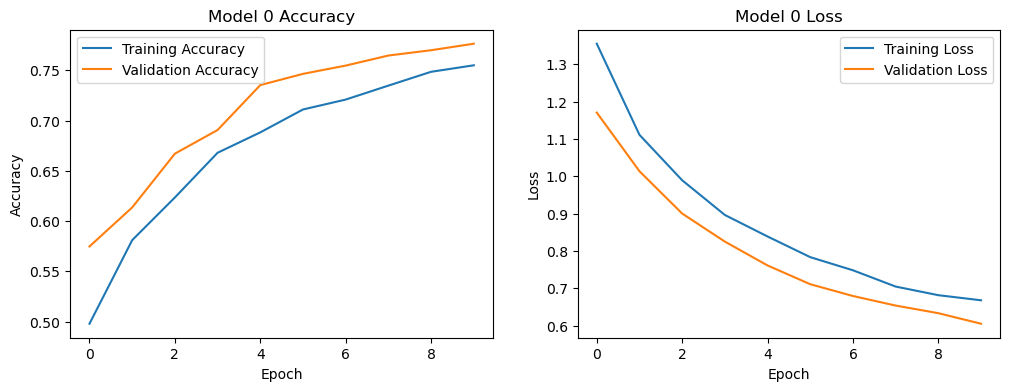

In [259]:
models = []
histories = []
sequential_models = True


for i, create_model in enumerate([audio_models.create_tiny_embed_conv_model_small]):
    print(f'\nTraining Model {i}')
    input_shape = (124, 129, 1)
    model = create_model(input_shape)
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    model.summary()


    history = model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=10,  # You can adjust the number of epochs
        callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=2, min_delta=0.01),
        verbose = 1
    )
    models.append(model)
    histories.append(history)
    
    plot_training_history(history, i)


## Compile and test models

In [260]:
len(models)

1

In [261]:


# Function to reload any serialized models (from bytes) if necessary
def load_if_serialized(model):
    if isinstance(model, bytes):
        # Assuming the model was saved as bytes, use `tf.keras.models.model_from_json` or similar
        raise TypeError("Model is in a serialized bytes format. Please load it as a Keras model before passing.")
    return model

def get_gzipped_model_size(model):
    # Save the model to a temporary file in .keras format
    with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as temp_file:
        model.save(temp_file.name)
        model_filename = temp_file.name

    # Compress the model file to calculate its gzipped size
    with tempfile.NamedTemporaryFile(suffix='.zip', delete=False) as temp_zip:
        zipped_file = temp_zip.name
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(model_filename, arcname='model.keras')

    # Get the size of the gzipped model file in kilobytes
    gzipped_size = os.path.getsize(zipped_file) / 1000  # Convert bytes to KB

    # Clean up temporary files
    os.remove(model_filename)
    os.remove(zipped_file)

    return gzipped_size

def plot_size_v_accuracy(models, test_spectrogram_ds):
    # Lists to store the results
    accuracies = []
    model_sizes = []
    model_names = []

    # Evaluate each model and store the results
    for i, model in enumerate(models, start=1):
        try:
            # Load model if it's in serialized bytes format
            model = load_if_serialized(model)

            # Check if model is a Keras model instance
            #if not isinstance(model, tf.keras.Model):
            #    raise TypeError(f"Model {i} is not a Keras model instance.")

            # Check if the model is compiled by looking for an optimizer
            if model.optimizer is None:
                model.compile(
                    optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy']
                )
            
            # Evaluate the model
            test_loss, test_acc = model.evaluate(test_spectrogram_ds, verbose=0)

            # Calculate the gzipped model size
            gzipped_size = get_gzipped_model_size(model)

            # Print the details
            print(f"Model {i} ({model.name}):")
            print(f"  Gzipped Model Size: {gzipped_size:.2f} KB")
            print(f"  Test Accuracy: {test_acc:.4f}")
            
            # Store the accuracy and model size
            accuracies.append(test_acc)
            model_sizes.append(gzipped_size)
            model_names.append(model.name)

        except Exception as e:
            print(f"An error occurred with Model {i}: {e}")

    # Plotting accuracy vs. gzipped model size
    plt.figure(figsize=(10, 6))
    plt.plot(model_sizes, accuracies, marker='o', linestyle='', color='b')

    for i, model_name in enumerate(model_names):
        plt.text(model_sizes[i], accuracies[i], model_name, fontsize=9, ha='right')

    # Add labels and title
    plt.xlabel('Gzipped Model Size (KB)')
    plt.ylabel('Test Accuracy')
    plt.title('Model Accuracy vs. Gzipped Model Size')
    plt.grid(True)
    plt.show()

# Example usage
# plot_size_v_accuracy(models, test_spectrogram_ds)



c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


Model 1 (tiny_embed_conv_model):
  Gzipped Model Size: 107.95 KB
  Test Accuracy: 0.7906


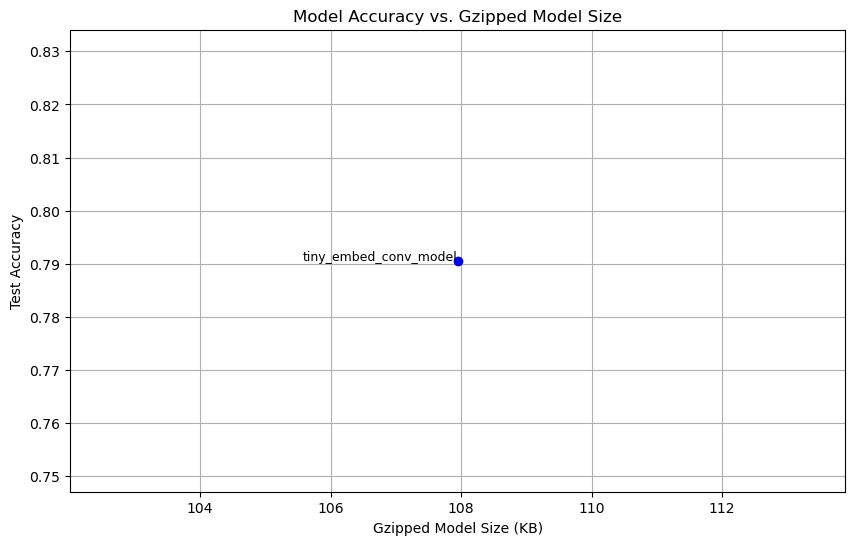

In [262]:
plot_size_v_accuracy(models, test_spectrogram_ds)

In [263]:
models

# Shrinking the model

[deployment on the edge](https://ai.google.dev/edge/litert)

[general model optimizations](https://www.tensorflow.org/model_optimization/guide)

We will start off with pruning

we will aslo try quantization aware training to quantize the model
and we will also try different post-training quantizations

we can also try weight clustering

and finalyl we will try a single workflow with a combination of the previous methods
[collaborative optimizations](https://www.tensorflow.org/model_optimization/guide/combine/collaborative_optimization)


https://blog.tensorflow.org/2024/04/faster-dynamically-quantized-inference-with-xnnpack.html



# Pruning (pruning oes not work with the generated models, ill have to fix that)

In [ ]:
### Helper functions for pruning

def ds_to_numpy(dataset):
    """Converts a tf.data.Dataset to numpy arrays for data and labels."""
    data = []
    labels = []
    
    for features, label in dataset:
        data.append(features)
        labels.append(label)

    data = tf.concat(data, axis=0)
    labels = tf.concat(labels, axis=0)
    return data, labels

def print_model_weights_sparsity(model):
    """Prints the sparsity (percentage of zeros) for each layer's weights in the model."""
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):  # For pruned layers wrapped in the pruning wrapper
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            weight_np = weight.numpy()
            weight_size = weight_np.size
            zero_num = np.count_nonzero(weight_np == 0)
            print(f"{weight.name}: {zero_num / weight_size:.2%} sparsity ({zero_num}/{weight_size})")
            
def sequential_to_functional(sequential_model):
    # Extract the layers from the Sequential model
    inputs = Input(shape=sequential_model.input_shape[1:])
    x = inputs

    # Apply each layer from the Sequential model in sequence
    for layer in sequential_model.layers:
        x = layer(x)
    
    # Create a new functional model
    functional_model = Model(inputs=inputs, outputs=x)
    
    # Copy weights from the Sequential model
    functional_model.set_weights(sequential_model.get_weights())

    print(functional_model)
    
    return functional_model

In [ ]:
def prune_model(model, train_spectrogram_ds, test_spectrogram_ds, qat=False):
    """Prunes the given model with optional quantization-aware training (QAT)."""
    # Ensure model is compatible with pruning by converting it to functional if needed
    #model = sequential_to_functional(model)
    
    # Convert datasets to numpy arrays
    train_data, train_labels = ds_to_numpy(train_spectrogram_ds)
    test_data, test_labels = ds_to_numpy(test_spectrogram_ds)

    # Define pruning parameters
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
    }
    
    # Define pruning callbacks
    callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

    # Apply pruning
    if qat:
        # Quantization-aware training with pruning
        quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(model)
        pruned_model = tfmot.quantization.keras.quantize_apply(
            quant_aware_annotate_model,
            tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme()
        )
    else:
        # Standard pruning
        pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

    # Compile the pruned model with a smaller learning rate for fine-tuning
    pruned_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    # Display model summary
    pruned_model.summary()

    # Fine-tune the pruned model
    pruned_model.fit(
        train_data,
        train_labels,
        epochs=3,
        validation_split=0.1,
        callbacks=callbacks
    )

    # Strip pruning wrappers for final deployment
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

    # Check sparsity levels
    print_model_weights_sparsity(stripped_pruned_model)

    # Evaluate the pruned model on test data
    _, pruned_model_accuracy = stripped_pruned_model.evaluate(test_data, test_labels, verbose=0)
    print("Pruned test accuracy:", pruned_model_accuracy)

    return stripped_pruned_model


In [272]:
models[0]

In [ ]:
basic_pruned_models = []

for model in models:
    pruned_model = prune_model(model, train_spectrogram_ds, test_spectrogram_ds, qat=False)
    basic_pruned_models.append(pruned_model)


Model: "tiny_embed_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv1   (None, 62, 65, 8)         1290      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_relu1   (None, 62, 65, 8)         1         
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 62, 65, 8)         1         
 t1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_conv2   (None, 8, 9, 8)           10250     
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_relu2   (None, 8, 9, 8) 

c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Model 1 (tiny_conv_model):
  Gzipped Model Size: 439.85 KB
  Test Accuracy: 0.7747
Model 2 (tiny_embed_conv_model):
  Gzipped Model Size: 24.18 KB
  Test Accuracy: 0.7900
Model 3 (tiny_embed_conv_model_best):
  Gzipped Model Size: 84.99 KB
  Test Accuracy: 0.8371


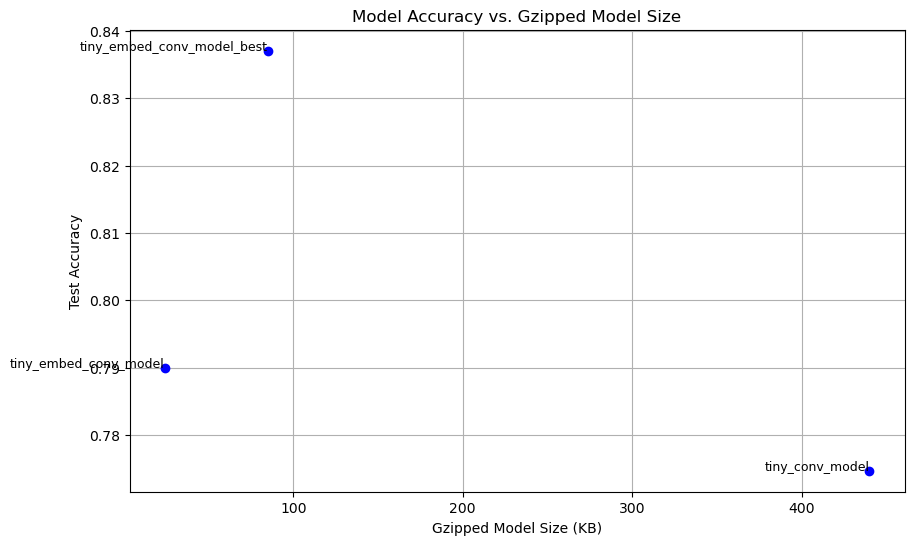

In [ ]:
plot_size_v_accuracy(basic_pruned_models, test_spectrogram_ds)


## Pruning preserving quantization aware training (PQAT)
https://www.tensorflow.org/model_optimization/guide/combine/pqat_example

## Sparsity and cluster preserving quantization aware training
https://www.tensorflow.org/model_optimization/guide/combine/pcqat_example

# Quantize models

https://www.tensorflow.org/model_optimization/guide

https://blog.tensorflow.org/2024/04/faster-dynamically-quantized-inference-with-xnnpack.html


we can also add some weight clustering?

## quantization aware training quantized models with or without pruning
https://www.tensorflow.org/model_optimization/guide/quantization/training_example

https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide#quantize_some_layers

In [17]:
#import tensorflow_model_optimization as tfmot

#quantization aware training with int8 weights and uint8 activations.
def qat(model, pruning = False, save = False):
  # translate model to be quantization aware
  quantize_model = tfmot.quantization.keras.quantize_model

  # Use `quantize_scope` to register the custom NoOpQuantizeConfig object
  with tfmot.quantization.keras.quantize_scope({'NoOpQuantizeConfig': audio_models.NoOpQuantizeConfig}):
      # Annotate the model for QAT
      quant_aware_annotated_model = tfmot.quantization.keras.quantize_annotate_model(model)
      
      # Apply QAT
      if pruning:
        q_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotated_model, 
                                                                tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())
      else:
        q_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotated_model)




  # Debug: Print model type and structure
  print(f"Model type: {type(model)}")
  print(f"Is Sequential: {isinstance(model, tf.keras.Sequential)}")
  print(f"Is Functional: {hasattr(model, '_is_graph_network') and model._is_graph_network}")
  model.summary()

  # Check if the model is Sequential or Functional
  if not isinstance(model, tf.keras.Sequential) and not (hasattr(model, '_is_graph_network') and model._is_graph_network):
    raise ValueError('`model` must be a Keras Sequential or Functional model.')

  #q_aware_model = quantize_model(quant_aware_model)

  q_aware_model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
  
  q_aware_model.summary()

  num_batches = tf.data.experimental.cardinality(train_spectrogram_ds).numpy()
  print(f"Number of batches in the training dataset: {num_batches}")

  # finetune quant aware model with quant aware training
  q_aware_model.fit(train_spectrogram_ds.take(num_batches // 4), batch_size = 100, epochs=1, validation_data=val_spectrogram_ds)



  _, baseline_model_accuracy = model.evaluate(test_spectrogram_ds, verbose=0)

  _, q_aware_model_accuracy = q_aware_model.evaluate(test_spectrogram_ds, verbose=0)

  print('Baseline test accuracy:', baseline_model_accuracy)
  print('Quant test accuracy:', q_aware_model_accuracy)

  if save:
    # now we haveint8 weights and uint8 activations.
    # Convert the model to TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    quantized_tflite_model = converter.convert()
    if pruning:
      model_filename = f'pruned_qat_{model.name}.tflite'
    else:
      model_filename = f'qat_{model.name}.tflite'
    # Save the quantized model
    with open(model_filename, 'wb') as f:
      f.write(quantized_tflite_model)

    return model_filename
  
  return q_aware_model


In [18]:
# Evaluate the TFLite quantized model
def evaluate_tflite_model(interpreter, dataset):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    total_samples = 0
    correct_predictions = 0

    for spectrograms, labels in dataset:
        input_data = spectrograms.numpy().astype('float32')
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        predictions = interpreter.get_tensor(output_details[0]['index'])
        predicted_labels = tf.argmax(predictions, axis=1)
        correct_predictions += tf.reduce_sum(tf.cast(predicted_labels == labels, tf.int32)).numpy()
        total_samples += labels.shape[0]

    accuracy = correct_predictions / total_samples
    return accuracy

In [19]:
quantized_qat_models = []
pruning_quantized_qat_models = []



for model in models:
    qat_tflite_model = qat(model, pruning = False, save=True)
    quantized_qat_models.append(qat_tflite_model)

for model in basic_pruned_models:
    pruned_qat_tflite_model = qat(model, pruning = True, save = True)
    pruning_quantized_qat_models.append(pruned_qat_tflite_model)



'''
# Evaluate the TFLite quantized model
interpreter = tf.lite.Interpreter(model_content=qat_models[0])
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


#quantized_model_accuracy = evaluate_tflite_model(interpreter, test_spectrogram_ds)
#print('Quantized TFLite model test accuracy:', quantized_model_accuracy)

'''


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 flatten (Flatten)           (None, 32240)             0         
                                                                 
 fc2 (Dense)                 (None, 6)                 193446    
                                                                 
Total params: 194094 (758.18 KB)
Trainable params: 194094 (758.18 KB)
Non-trai

INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpwuq6fl8z\assets


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_embed_conv_model"


c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 8, 9, 8)           5128      
                                                                 
 relu2 (ReLU)                (None, 8, 9, 8)           0         
                                                                 
 dropout2 (Dropout)          (None, 8, 9, 8)           0         
                                                                 
 flatten (Flatten)           (None, 576)               0         
          

c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


213/213 [==============================] - 4s 16ms/step - loss: 0.6420 - accuracy: 0.7640 - val_loss: 0.5736 - val_accuracy: 0.7994
Baseline test accuracy: 0.7900000214576721
Quant test accuracy: 0.7911764979362488
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp8ir9ds8u\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp8ir9ds8u\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_embed_conv_model_best"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 129, 16)       1312      
                                                                 
 relu1 (ReLU)                (None, 62, 129, 16)       0         
                                                                 
 dropout1 (Dropout)          (None, 62, 129, 16)       0         
                                                                 
 conv2 (Conv2D)              (None, 16, 22, 12)        9420      
                                                                 
 relu2 (ReLU)                (None, 16, 22, 12)        0         
                                                                 
 dropout2 (Dropout)          (None, 16, 22, 12)        0         
 

c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


213/213 [==============================] - 11s 48ms/step - loss: 0.4137 - accuracy: 0.8478 - val_loss: 0.4586 - val_accuracy: 0.8435
Baseline test accuracy: 0.8370588421821594
Quant test accuracy: 0.8382353186607361
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpbmd7408_\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpbmd7408_\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 flatten (Flatten)           (None, 32240)             0         
                                                                 
 fc2 (Dense)                 (None, 6)                 193446    
                                                                 
Total params: 194094 (758.18 KB)
Trainable params: 194094 (758.18 KB)
Non-trai

c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


213/213 [==============================] - 4s 16ms/step - loss: 0.3311 - accuracy: 0.8847 - val_loss: 0.5829 - val_accuracy: 0.8153
Baseline test accuracy: 0.7747058868408203
Quant test accuracy: 0.8082352876663208
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpcnj749o2\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpcnj749o2\assets


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_embed_conv_model"


c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 8, 9, 8)           5128      
                                                                 
 relu2 (ReLU)                (None, 8, 9, 8)           0         
                                                                 
 dropout2 (Dropout)          (None, 8, 9, 8)           0         
                                                                 
 flatten (Flatten)           (None, 576)               0         
          

c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


213/213 [==============================] - 4s 17ms/step - loss: 0.6301 - accuracy: 0.7652 - val_loss: 0.5820 - val_accuracy: 0.7906
Baseline test accuracy: 0.7900000214576721
Quant test accuracy: 0.7911764979362488
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpl1xogsbo\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpl1xogsbo\assets


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_embed_conv_model_best"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 129, 16)       1312      
                                                                 
 relu1 (ReLU)                (None, 62, 129, 16)       0         


c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


                                                                 
 dropout1 (Dropout)          (None, 62, 129, 16)       0         
                                                                 
 conv2 (Conv2D)              (None, 16, 22, 12)        9420      
                                                                 
 relu2 (ReLU)                (None, 16, 22, 12)        0         
                                                                 
 dropout2 (Dropout)          (None, 16, 22, 12)        0         
                                                                 
 flatten (Flatten)           (None, 4224)              0         
                                                                 
 fc2 (Dense)                 (None, 6)                 25350     
                                                                 
Total params: 36082 (140.95 KB)
Trainable params: 36082 (140.95 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


213/213 [==============================] - 10s 45ms/step - loss: 0.4016 - accuracy: 0.8518 - val_loss: 0.4763 - val_accuracy: 0.8324
Baseline test accuracy: 0.8370588421821594
Quant test accuracy: 0.8417646884918213
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp51a8usp1\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp51a8usp1\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


"\n# Evaluate the TFLite quantized model\ninterpreter = tf.lite.Interpreter(model_content=qat_models[0])\ninterpreter.allocate_tensors()\n\ninput_details = interpreter.get_input_details()\noutput_details = interpreter.get_output_details()\n\n\n#quantized_model_accuracy = evaluate_tflite_model(interpreter, test_spectrogram_ds)\n#print('Quantized TFLite model test accuracy:', quantized_model_accuracy)\n\n"

In [20]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in kilobytes.

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)/1000


In [21]:
for file in quantized_qat_models:
  print(f"Model: {file}")
  print(f"Size: {get_gzipped_model_size(file)} KB")

for file in pruning_quantized_qat_models:
  print(f"Model: {file}")
  print(f"Size: {get_gzipped_model_size(file)} KB")

Model: qat_tiny_conv_model.tflite
Size: 135.81 KB
Model: qat_tiny_embed_conv_model.tflite
Size: 8.961 KB
Model: qat_tiny_embed_conv_model_best.tflite
Size: 29.192 KB
Model: pruned_qat_tiny_conv_model.tflite
Size: 111.224 KB
Model: pruned_qat_tiny_embed_conv_model.tflite
Size: 8.596 KB
Model: pruned_qat_tiny_embed_conv_model_best.tflite
Size: 25.807 KB


In [22]:
#to see persistence of accuracy from tf to tflite
def eval_model(interpreter):
  test_images, test_labels = ds_to_numpy(test_spectrogram_ds)
  
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print(f"Evaluated on {i} results so far.")
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = np.mean((prediction_digits == test_labels))
  return accuracy


In [23]:
pqat_model_file = "C:\\Users\\adamk\\Downloads\\micro_speech_model_making\\notebooks\\pruned_qat_tiny_embed_conv_model.tflite"
interpreter = tf.lite.Interpreter(pqat_model_file)
interpreter.allocate_tensors()

pqat_test_accuracy = eval_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', pqat_test_accuracy)


Evaluated on 0 results so far.
Evaluated on 1000 results so far.


Pruned and quantized TFLite test_accuracy: 0.7923529411764706


## Post training quantization

https://ai.google.dev/edge/litert/models/post_training_quant

In [24]:
# Function to quantize the models using TensorFlow Lite Micro with different granularities
def quantize_model(model, optimization_strategy):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    if optimization_strategy == 'weight':
        # Quantize only weights
        converter.target_spec.supported_types = [tf.float16]
    elif optimization_strategy == 'full':
        # Full integer quantization
        def representative_dataset():
            for spectrogram, _ in train_spectrogram_ds.take(1000):
                yield [spectrogram]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
    elif optimization_strategy == 'dynamic':
        # Dynamic range quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    else:
        raise ValueError("Unsupported optimization strategy. Use 'weight', 'full', or 'dynamic'.")
    tflite_model = converter.convert()
    return tflite_model


In [25]:
# Function to quantize the models using post-training integer quantization with int16 activations and int8 weights
def quantize_model_int16x8(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    def representative_dataset():
        for spectrogram, _ in train_spectrogram_ds.take(100):
            yield [spectrogram]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
    converter.inference_input_type = tf.int16
    converter.inference_output_type = tf.int16
    tflite_model = converter.convert()
    return tflite_model

In [26]:
# Quantize each trained model with different granularities and save them
quantization_strategies = ['weight', 'full', 'dynamic']

for i, model in enumerate(basic_pruned_models):
    for strategy in quantization_strategies:
        print(f'Quantizing Model {i} with {strategy} strategy')
        tflite_model = quantize_model(model, strategy)
        model_filename = f'model_{i}_{strategy}_quantized.tflite'
        with open(model_filename, 'wb') as f:
            f.write(tflite_model)
        print(f'Model {i} quantized with {strategy} strategy and saved as {model_filename}')

    # Quantize using post-training integer quantization with int16 activations and int8 weights
    print(f'Quantizing Model {i} with int16 activations and int8 weights')
    tflite_model_int16x8 = quantize_model_int16x8(model)
    model_filename_int16x8 = f'model_{i}_int16x8_quantized.tflite'
    with open(model_filename_int16x8, 'wb') as f:
        f.write(tflite_model_int16x8)
    print(f'Model {i} quantized with int16 activations and int8 weights and saved as {model_filename_int16x8}')

Quantizing Model 0 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpf03bngwx\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpf03bngwx\assets


Model 0 quantized with weight strategy and saved as model_0_weight_quantized.tflite
Quantizing Model 0 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmprvejtmx1\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmprvejtmx1\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 0 quantized with full strategy and saved as model_0_full_quantized.tflite
Quantizing Model 0 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpz9843a_6\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpz9843a_6\assets


Model 0 quantized with dynamic strategy and saved as model_0_dynamic_quantized.tflite
Quantizing Model 0 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp6hjp4zy4\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp6hjp4zy4\assets


Model 0 quantized with int16 activations and int8 weights and saved as model_0_int16x8_quantized.tflite
Quantizing Model 1 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp62xlj0sy\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp62xlj0sy\assets


Model 1 quantized with weight strategy and saved as model_1_weight_quantized.tflite
Quantizing Model 1 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpxgwtu45_\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpxgwtu45_\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 1 quantized with full strategy and saved as model_1_full_quantized.tflite
Quantizing Model 1 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpsh9ep2i9\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpsh9ep2i9\assets


Model 1 quantized with dynamic strategy and saved as model_1_dynamic_quantized.tflite
Quantizing Model 1 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp0a6pgs3y\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp0a6pgs3y\assets


Model 1 quantized with int16 activations and int8 weights and saved as model_1_int16x8_quantized.tflite
Quantizing Model 2 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp3jh1ckx9\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp3jh1ckx9\assets


Model 2 quantized with weight strategy and saved as model_2_weight_quantized.tflite
Quantizing Model 2 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp495k09lo\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp495k09lo\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 2 quantized with full strategy and saved as model_2_full_quantized.tflite
Quantizing Model 2 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpt07mzndi\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpt07mzndi\assets


Model 2 quantized with dynamic strategy and saved as model_2_dynamic_quantized.tflite
Quantizing Model 2 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpvoyzaeyo\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpvoyzaeyo\assets


Model 2 quantized with int16 activations and int8 weights and saved as model_2_int16x8_quantized.tflite


## Quantized Model Evaluation

In [27]:
# Function to evaluate the quantized models
def evaluate_quantized_model(tflite_model_path):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Determine the expected input type
    input_dtype = input_details[0]['dtype']


    # Evaluate the model on the test dataset
    total_correct = 0
    total_samples = 0

    for spectrogram_batch, label_batch in test_spectrogram_ds:
        for spectrogram, label in zip(spectrogram_batch, label_batch):
            interpreter.set_tensor(input_details[0]['index'], np.expand_dims(spectrogram, axis=0).astype(input_dtype))
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            predicted_label = np.argmax(output_data)
            total_correct += (predicted_label == label.numpy())
            total_samples += 1

    accuracy = total_correct / total_samples
    return accuracy

In [29]:
# Evaluate each quantized model
for i in range(0, len(models)):
    for strategy in quantization_strategies:
        model_filename = f'model_{i}_{strategy}_quantized.tflite'
        print(f'Evaluating Model {i} with {strategy} quantization')
        accuracy = evaluate_quantized_model(model_filename)
        print(f'Model {i} with {strategy} quantization accuracy: {accuracy:.4f}')

    model_filename_int16x8 = f'model_{i}_int16x8_quantized.tflite'
    print(f'Evaluating Model {i} with int16 activations and int8 weights quantization')
    accuracy = evaluate_quantized_model(model_filename_int16x8)
    print(f'Model {i} with int16 activations and int8 weights quantization accuracy: {accuracy:.4f}')

Evaluating Model 0 with weight quantization
Model 0 with weight quantization accuracy: 0.7747
Evaluating Model 0 with full quantization
Model 0 with full quantization accuracy: 0.0600
Evaluating Model 0 with dynamic quantization
Model 0 with dynamic quantization accuracy: 0.7735
Evaluating Model 0 with int16 activations and int8 weights quantization
Model 0 with int16 activations and int8 weights quantization accuracy: 0.0600
Evaluating Model 1 with weight quantization
Model 1 with weight quantization accuracy: 0.7900
Evaluating Model 1 with full quantization
Model 1 with full quantization accuracy: 0.0600
Evaluating Model 1 with dynamic quantization
Model 1 with dynamic quantization accuracy: 0.7918
Evaluating Model 1 with int16 activations and int8 weights quantization
Model 1 with int16 activations and int8 weights quantization accuracy: 0.0600
Evaluating Model 2 with weight quantization
Model 2 with weight quantization accuracy: 0.8371
Evaluating Model 2 with full quantization
Mode

In [30]:
# Function to print the size and memory requirements of the quantized models
def print_quantized_model_sizes(model_filenames):
    sizes = []
    for model_filename in model_filenames:
        if os.path.exists(model_filename):
            model_size = os.path.getsize(model_filename) / 1024  # Size in KB
            sizes.append((model_filename, model_size))
            print(f'Model: {model_filename} Size: {model_size:.2f} KB')
        else:
            print(f'Model: {model_filename} not found.')
    return sizes


Quantized Model Sizes:
Model: model_0_weight_quantized.tflite Size: 381.72 KB
Model: model_0_full_quantized.tflite Size: 192.59 KB
Model: model_0_dynamic_quantized.tflite Size: 193.58 KB
Model: model_0_int16x8_quantized.tflite Size: 192.61 KB
Model: model_1_weight_quantized.tflite Size: 21.38 KB
Model: model_1_full_quantized.tflite Size: 12.82 KB
Model: model_1_dynamic_quantized.tflite Size: 13.66 KB
Model: model_1_int16x8_quantized.tflite Size: 12.99 KB
Model: model_2_weight_quantized.tflite Size: 73.88 KB
Model: model_2_full_quantized.tflite Size: 39.41 KB
Model: model_2_dynamic_quantized.tflite Size: 38.36 KB
Model: model_2_int16x8_quantized.tflite Size: 39.74 KB
Evaluating model_0_weight_quantized.tflite
Evaluating model_0_full_quantized.tflite
Evaluating model_0_dynamic_quantized.tflite
Evaluating model_0_int16x8_quantized.tflite
Evaluating model_1_weight_quantized.tflite
Evaluating model_1_full_quantized.tflite
Evaluating model_1_dynamic_quantized.tflite
Evaluating model_1_int16

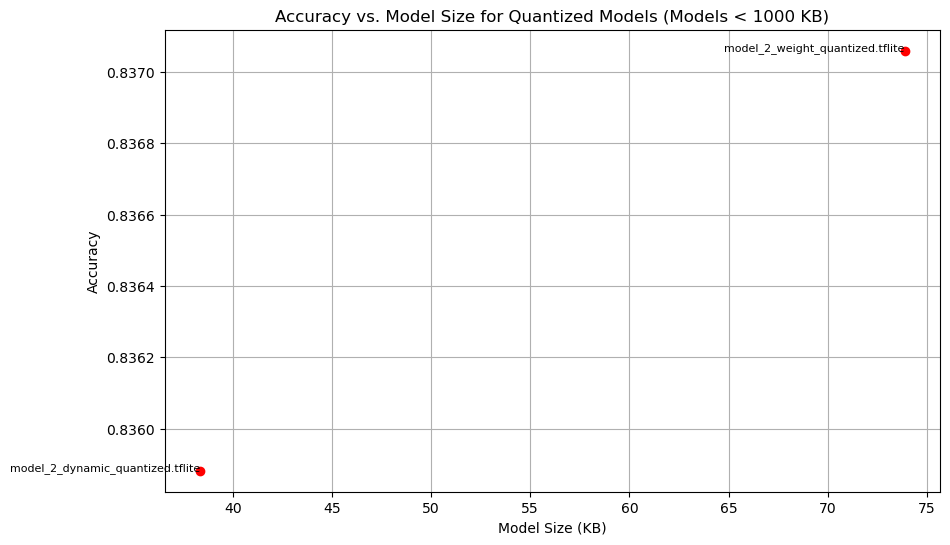

In [32]:
# List of quantized model filenames
quantized_model_filenames = []
for i in range(0, len(models)):
    for strategy in ['weight', 'full', 'dynamic']:
        quantized_model_filenames.append(f'model_{i}_{strategy}_quantized.tflite')
    quantized_model_filenames.append(f'model_{i}_int16x8_quantized.tflite')

# Print sizes of quantized models and store the sizes
print("\nQuantized Model Sizes:")
quantized_model_sizes = print_quantized_model_sizes(quantized_model_filenames)

# Evaluate each quantized model and collect accuracies
quantized_accuracies = []

for model_filename, model_size in quantized_model_sizes:
    print(f'Evaluating {model_filename}')
    accuracy = evaluate_quantized_model(model_filename)
    quantized_accuracies.append((model_filename, model_size, accuracy))

# Filter accuracies for models smaller than 1000 KB and accuracy greater than 0.8
filtered_accuracies = [tup for tup in quantized_accuracies if tup[2] > 0.8 and tup[1] < 1000]

# Plot accuracy vs. model size for quantized models
model_names, model_sizes, accuracies = zip(*filtered_accuracies)

plt.figure(figsize=(10, 6))

# Plot points without connecting lines by setting linestyle='None'
plt.plot(model_sizes, accuracies, marker='o', linestyle='None', color='r')

# Annotate each point with the model name
for i, model_name in enumerate(model_names):
    plt.text(model_sizes[i], accuracies[i], model_name, fontsize=8, ha='right')

plt.xlabel('Model Size (KB)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Model Size for Quantized Models (Models < 1000 KB)')
plt.grid(True)
plt.show()


In [33]:
def evaluate_tflite_model(tflite_model_path, test_data, test_labels):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Determine input data type
    input_dtype = input_details[0]['dtype']
    
    # Run inference on the test data
    correct_predictions = 0
    for i, test_sample in enumerate(test_data):
        # Prepare input data, converting to expected dtype if necessary
        input_data = np.expand_dims(test_sample, axis=0)
        if input_dtype == np.uint8:
            input_data = (input_data * 255).astype(np.uint8)  # Scale to UINT8
        else:
            input_data = input_data.astype(input_dtype)

        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run inference
        interpreter.invoke()
        
        # Get the output and check the prediction
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output_data)
        true_label = test_labels[i]
        
        if predicted_label == true_label:
            correct_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / len(test_data)
    return accuracy


def plot_tflite_size_vs_accuracy(folder_path, test_spectrogram_ds):
    test_data, test_labels = ds_to_numpy(test_spectrogram_ds)
    # Lists to store results
    model_sizes = []
    accuracies = []
    model_names = []
    
    # Iterate through all TFLite files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".tflite"):
            model_path = os.path.join(folder_path, filename)
            model_name = os.path.splitext(filename)[0]
            
            # Get model size in KB
            model_size = os.path.getsize(model_path) / 1000  # Convert bytes to KB
            
            # Evaluate the TFLite model accuracy
            accuracy = evaluate_tflite_model(model_path, test_data, test_labels)
            
            # Store results
            model_sizes.append(model_size)
            accuracies.append(accuracy)
            model_names.append(model_name)
            
            # Print the details
            print(f"Model: {model_name}, Size: {model_size:.2f} KB, Accuracy: {accuracy:.4f}")
    
    # Plotting accuracy vs. model size
    plt.figure(figsize=(10, 6))
    plt.plot(model_sizes, accuracies, marker='o', linestyle='', color='b')

    # Annotate each point with the model name
    for i, model_name in enumerate(model_names):
        plt.text(model_sizes[i], accuracies[i], model_name, fontsize=9, ha='right')

    # Add labels and title
    plt.xlabel('Model Size (KB)')
    plt.ylabel('Test Accuracy')
    plt.title('TFLite Model Accuracy vs. Model Size')
    plt.grid(True)
    plt.show()

    return model_sizes, accuracies, model_names


Model: model_0_dynamic_quantized, Size: 198.22 KB, Accuracy: 0.7735
Model: model_0_full_quantized, Size: 197.22 KB, Accuracy: 0.7659
Model: model_0_int16x8_quantized, Size: 197.23 KB, Accuracy: 0.0600
Model: model_0_weight_quantized, Size: 390.88 KB, Accuracy: 0.7747
Model: model_1_dynamic_quantized, Size: 13.99 KB, Accuracy: 0.7918
Model: model_1_full_quantized, Size: 13.13 KB, Accuracy: 0.7894
Model: model_1_int16x8_quantized, Size: 13.30 KB, Accuracy: 0.0600
Model: model_1_weight_quantized, Size: 21.90 KB, Accuracy: 0.7900
Model: model_2_dynamic_quantized, Size: 39.28 KB, Accuracy: 0.8359
Model: model_2_full_quantized, Size: 40.35 KB, Accuracy: 0.8412
Model: model_2_int16x8_quantized, Size: 40.70 KB, Accuracy: 0.0600
Model: model_2_weight_quantized, Size: 75.66 KB, Accuracy: 0.8371
Model: pruned_qat_tiny_conv_model, Size: 197.30 KB, Accuracy: 0.8076
Model: pruned_qat_tiny_embed_conv_model, Size: 13.34 KB, Accuracy: 0.7924
Model: pruned_qat_tiny_embed_conv_model_best, Size: 40.61 KB,

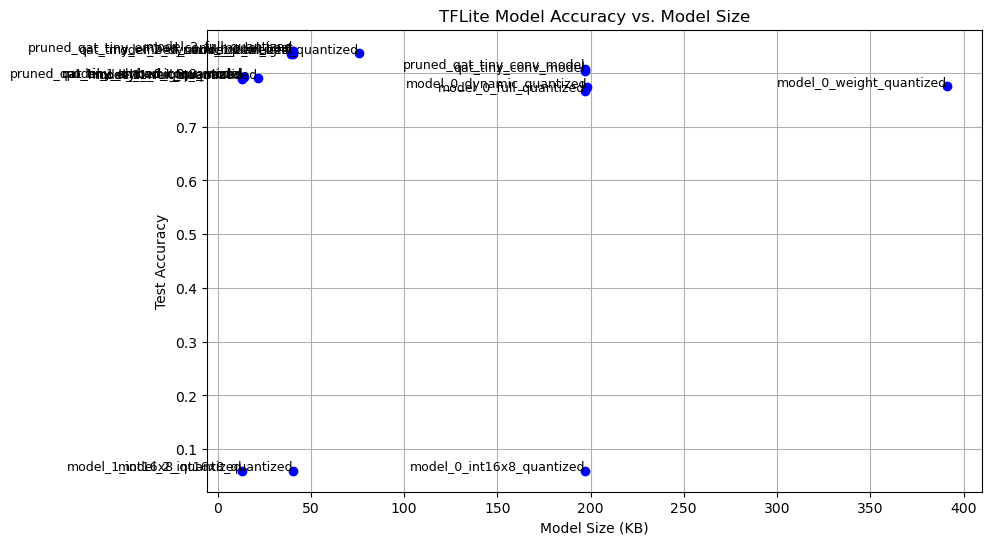

In [34]:
model_sizes, accuracies, model_names = [], [], []
folder_path = "C:\\Users\\adamk\\Downloads\\micro_speech_model_making\\notebooks\\"
model_sizes, accuracies, model_names = plot_tflite_size_vs_accuracy(folder_path, test_spectrogram_ds)
# C:\Users\adamk\Downloads\micro_speech_model_making\notebooks\val_spec_ds.tfrecord

In [35]:
for size, acc, name in zip(model_sizes, accuracies, model_names):
    if size < 45 and acc > 0.8:
        print(f"Name : {name}, Size: {size}, Accuracy: {acc}")

Name : model_2_dynamic_quantized, Size: 39.28, Accuracy: 0.8358823529411765
Name : model_2_full_quantized, Size: 40.352, Accuracy: 0.8411764705882353
Name : pruned_qat_tiny_embed_conv_model_best, Size: 40.608, Accuracy: 0.84
Name : qat_tiny_embed_conv_model_best, Size: 40.608, Accuracy: 0.8358823529411765


In [ ]:
def plot_filtered_model_size_vs_accuracy(model_sizes, accuracies, model_names, max_size, min_accuracy):
    # Filter models based on the provided criteria
    filtered_sizes = [size for size, acc in zip(model_sizes, accuracies) if size < max_size and acc > min_accuracy]
    filtered_accuracies = [acc for size, acc in zip(model_sizes, accuracies) if size < max_size and acc > min_accuracy]
    filtered_names = [name for size, acc, name in zip(model_sizes, accuracies, model_names) if size < max_size and acc > min_accuracy]

    # Print details of filtered models
    for size, acc, name in zip(filtered_sizes, filtered_accuracies, filtered_names):
        print(f"Name: {name}, Size: {size:.2f} KB, Accuracy: {acc:.4f}")

    # Plot only the filtered models
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_sizes, filtered_accuracies, marker='o', linestyle='', color='b', label=f"Size < {max_size} KB & Accuracy > {min_accuracy*100}%")
    
    # Annotate each filtered point with the model name
    for i, model_name in enumerate(filtered_names):
        plt.text(filtered_sizes[i], filtered_accuracies[i], model_name, fontsize=9, ha='right')

    # Add labels and title
    plt.xlabel('Model Size (KB)')
    plt.ylabel('Test Accuracy')
    plt.title(f'TFLite Model Accuracy vs. Model Size (Filtered by Size < {max_size} KB & Accuracy > {min_accuracy*100}%)')
    plt.legend()
    plt.grid(True)
    plt.show()




Name: model_1_dynamic_quantized, Size: 13.99 KB, Accuracy: 0.7918
Name: model_1_full_quantized, Size: 13.13 KB, Accuracy: 0.7894
Name: model_1_weight_quantized, Size: 21.90 KB, Accuracy: 0.7900
Name: model_2_dynamic_quantized, Size: 39.28 KB, Accuracy: 0.8359
Name: model_2_full_quantized, Size: 40.35 KB, Accuracy: 0.8412
Name: pruned_qat_tiny_embed_conv_model, Size: 13.34 KB, Accuracy: 0.7924
Name: pruned_qat_tiny_embed_conv_model_best, Size: 40.61 KB, Accuracy: 0.8400
Name: qat_tiny_embed_conv_model, Size: 13.34 KB, Accuracy: 0.7918
Name: qat_tiny_embed_conv_model_best, Size: 40.61 KB, Accuracy: 0.8359


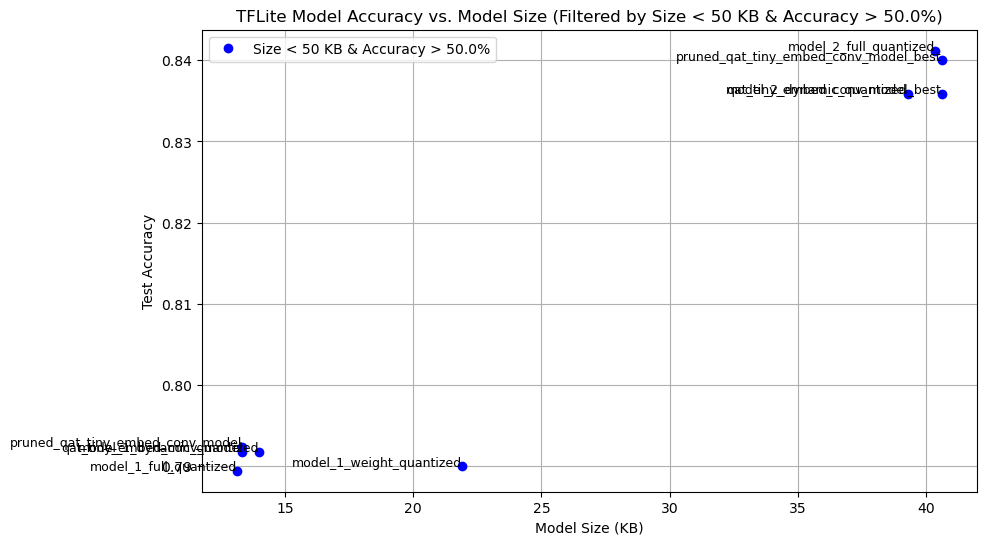

In [45]:
plot_filtered_model_size_vs_accuracy(model_sizes, accuracies, model_names, max_size=50, min_accuracy=0.50)